# Clustering and Decision Trees for Exploratory Data Analysis

This demonstration shows the process of how to use **KMeans Clustering** to perform **Exploratory Data Analysis** on a dataset in order to understand and group the data.

**Decision Trees** are a supervised machine learning technique that can be used to interpet the KMeans Clustering output in order to understand how to data was separated and grouped.

**Matplotlib** and **Seaborn** are used to visualize the results to users

This process will also show how the optimal # of clusters is found and how to extract feature importances relative to clustering

In [1]:
# Import
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import load_wine
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import tree
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Step1: Data Preprocessing

The Scitkit-Learn Wine dataset is used to demonstrate the process. This dataset consists of 13 features

In [2]:
# Load Dataset
data = load_wine()
inputDF = pd.DataFrame(data = np.array(data.data), columns = data.feature_names)

# Separate the independent and dependent variables
X_data = data.data
target = data.target

Standardization of our dataset is done to ensure that certain features with larger values or larger ranges won't out-weigh other features. This ensures that the results from clustering are accurate.

In [3]:
# Standardize Data
standard_data = preprocessing.scale(X_data)
scaled_inputDF = pd.DataFrame(data = np.array(standard_data), columns = data.feature_names)

# Use the following statements to observe the changes in mean and std before
# and after standardization. scaled_inputDF should show ~0 mean and ~1 std for each feature
# inputDF.describe()        # Before Standardization
# scaled_inputDF.describe() # After Standardization

## Step 2: Clustering (Unsupervised Machine Learning)




The first step of KMeans Clustering involves finding the optimal value for k (k meaning the number of clusters) that best fits the data. There are two methods for finding the optimal value for k:
- **Elbow Method**
- **Silhouette Method**

In [4]:
# Determine Best Value for K
wcss = []
sil = []
for number_of_clusters in range (1,11):
  kmeans = KMeans(n_clusters = number_of_clusters, random_state = 2)
  kmeans.fit(standard_data)
  wcss.append(kmeans.inertia_)
  # Silhouette method requires atleast 2 clusters
  if(number_of_clusters >= 2):
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled_inputDF,labels, metric = 'euclidean'))

### Elbow Method

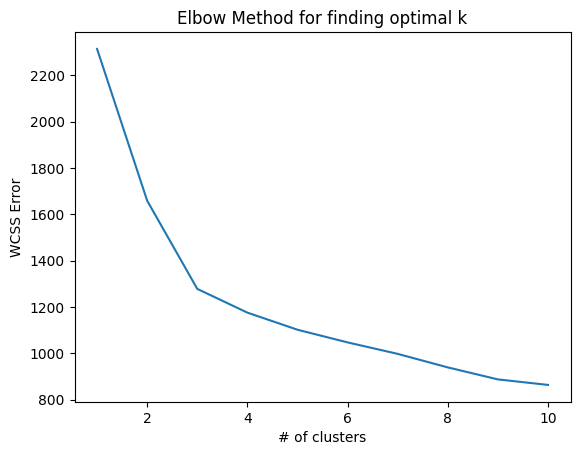

In [5]:
# Elbow Method
ks_wcss = [i for i in range(1,11)]
plt.plot(ks_wcss, wcss)
plt.title('Elbow Method for finding optimal k')
plt.xlabel('# of clusters')
plt.ylabel('WCSS Error')
plt.show()

Looking at the graph above, there appears to be an "elbow" around k = 3. Therefore, through the elbow method, 3 clusters is optimal.

### Silhouette Method

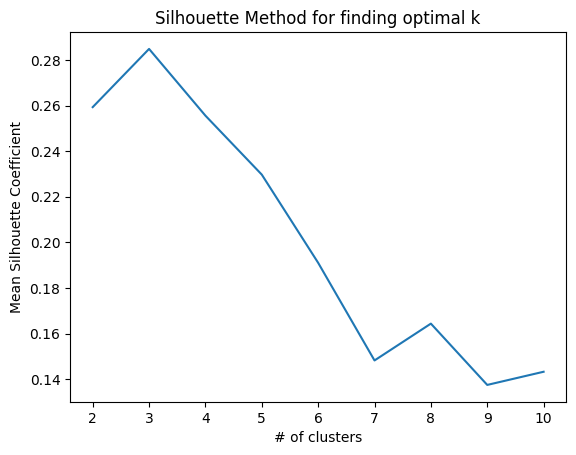

In [6]:
ks_sil = [i for i in range(2,11)]
plt.plot(ks_sil, sil)
plt.title('Silhouette Method for finding optimal k')
plt.xlabel('# of clusters')
plt.ylabel('Mean Silhouette Coefficient')
plt.show()

Looking at the graph above, a maximum mean silhouette coefficient value is achieved at k = 3. Therefore, through the silhouette method, 3 clusters is optimal. This also matches the results from the Elbow method so we will proceed with **k = 3 clusters**.

## Step3: KMeans Clustering (Using the optimal # of clusters)

In [7]:
k = 3
kmeans = KMeans(n_clusters = k, random_state =  2)
kmeans.fit(standard_data)

KMeans(n_clusters=3, random_state=2)

## Step4: Analyze and Plot Clustering Results


###Visualize Clustering Results using PCA

Principle component analysis (PCA) can be used to plot the data onto a 2d plot of 2 principal components with the plots colored according to the cluster they belong to from the KMeans Results.

In [8]:
# Perform PCA
pca = PCA(n_components = 2)
pca.fit(scaled_inputDF)
X_reduced = pca.transform(scaled_inputDF) # X feature data reduced to two principal components
X_reducedDF = pd.DataFrame(X_reduced, index = scaled_inputDF.index,
                           columns = ['PC1','PC2'])
X_reducedDF['cluster'] = kmeans.labels_ # Kmeans Output Labels

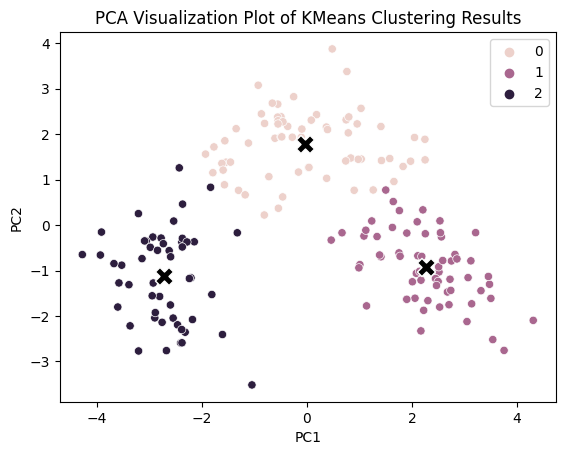

In [9]:
# Plot Clusters using PCA (including centroids)
ax = plt.subplots()
ax = sb.scatterplot(x = X_reducedDF['PC1'], y = X_reducedDF['PC2'], hue = X_reducedDF['cluster'])
centroids_reduced = pca.transform(kmeans.cluster_centers_)
ax = sb.scatterplot(x = centroids_reduced[:,0], y = centroids_reduced[:,1],
                    marker = 'X', color = 'k', s = 170)
plt.title('PCA Visualization Plot of KMeans Clustering Results')
plt.show()

The above PCA plot shows the separated clusters from the KMeans clustering we have performed previously. This shows that the KMeans was effective in clustering the data into 3 distinct groups. Further on in the demonstration, we will show how we can use decision trees to separate the groups of new or existing data points using the feature values

### Additional Analysis using Parallel Coordinate Plots

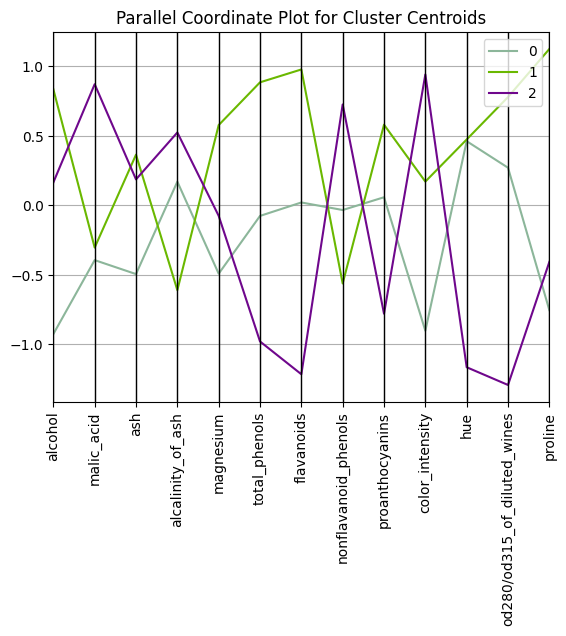

In [10]:
# Plot Centroids Parallel Coordinates
centroids = pd.DataFrame(kmeans.cluster_centers_,columns = scaled_inputDF.columns)
centroids['cluster'] = centroids.index
pd.plotting.parallel_coordinates(centroids,'cluster')
plt.title('Parallel Coordinate Plot for Cluster Centroids')
plt.xticks(rotation=90)
plt.show()

These parallel coordinate plots can be used to determine how the different features compare between the different clusters created from the KMeans Clustering we performed previously.

For example, we can see that the clusters differ notably for the features *flavanoids* and *color_intensity*. At the same time, features like *ash* are not as different across the 3 clusters.

### Feature Analysis using PCA

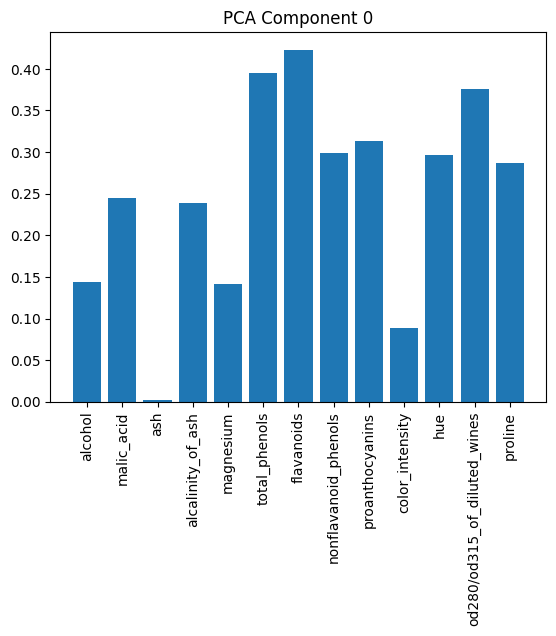

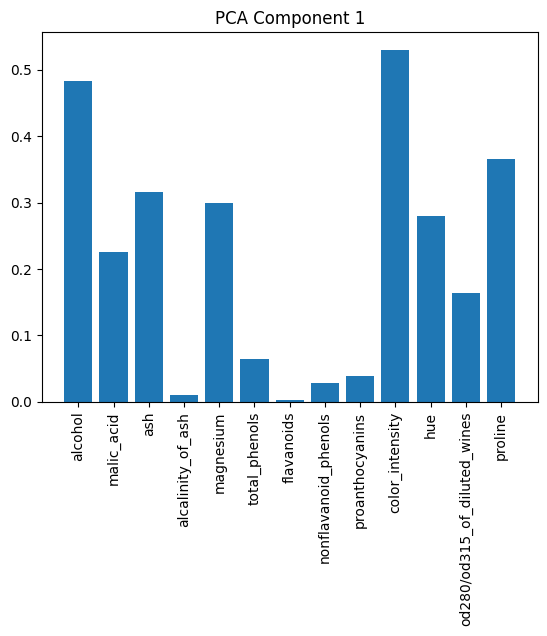

In [11]:
# Plot PCA Feature Analysis
pca_results = pca.components_

# First Principal Component
plt.bar(scaled_inputDF.columns,abs(pca_results[0,:]))
plt.xticks(rotation = 90)
plt.title('PCA Component 0')
plt.show()

# Second Principal Component
plt.bar(scaled_inputDF.columns,abs(pca_results[1,:]))
plt.xticks(rotation = 90)
plt.title('PCA Component 1')
plt.show()

These plots above gives us an indication of which features make an impact on the two principal compents used to plot the separated clusters.

For example, the first component's main feature is flavanoids and the second component's main feature being color intensity. Lets try seeing how we can use these two features to separate the data points:

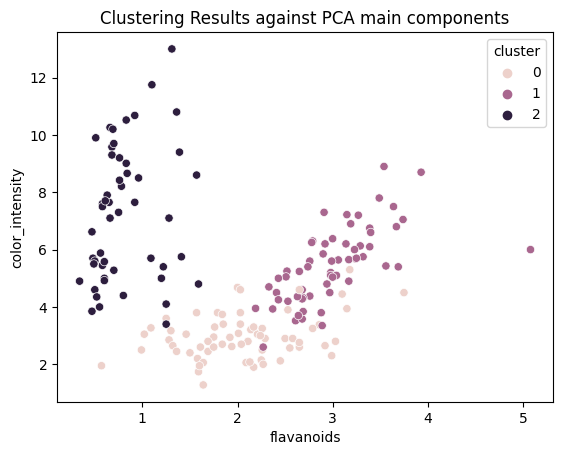

In [12]:
# Plot clusters using the two main features of PCA
sb.scatterplot(x = inputDF['flavanoids'], y = inputDF['color_intensity'], hue = X_reducedDF['cluster'])
plt.title('Clustering Results against PCA main components')
plt.show()

The plot above shows that we can somewhat separate out the datapoints into the 3 clusters using only 2 of the features. **For example, cluster 2 appears to have a color_intensity above 3 and flavanoids below 2.**

We can further improve on this using a supervised machine learning technique like **Decision Trees**

## Step5: Decision Trees

### Classifier Training
After performing the **KMeans Clustering**, we will now use the cluster labels to train a **Decision Tree** in order to learn how to separate the existing data or any new data points. **Decision Trees** are a great supervised ML technique for this task because they are easy to interpret and to apply to datasets.

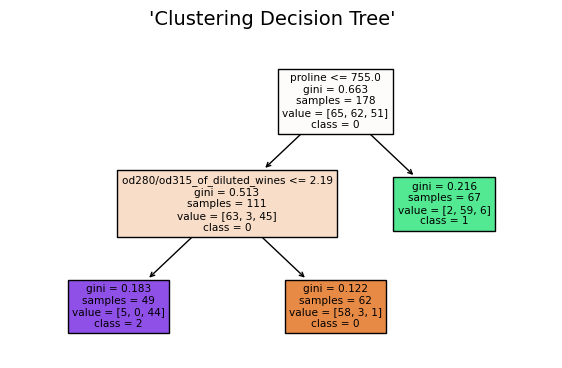

In [31]:
# Train Decision Tree on Dataset
classNames = [str(n) for n in range(0,max(np.unique(kmeans.labels_))+1)]
minSamplesLeaf = round(len(inputDF)*0.08) #8% of the dataset per leaf
maxDepth = 4 # Depth to keep readability

fig = figure(figsize=(7,4)).suptitle("'Clustering Decision Tree'",fontsize=14)
clf = tree.DecisionTreeClassifier(random_state=0,
                                  max_depth = maxDepth,
                                  min_samples_leaf = minSamplesLeaf,
                                  ccp_alpha = 0.04)
clf = clf.fit(inputDF, kmeans.labels_)

# Plot Decision Tree
tree.plot_tree(clf, feature_names = inputDF.columns, class_names = classNames,
               filled = True, impurity = True)
plt.show()

Looking at the diagram above of the trained decision tree, we can see how two of the features are used to determine which of the 3 clusters a given data point belongs to. We can then use a scatterplot to visualize how the decision tree output compares to the KMeans Clustering results.

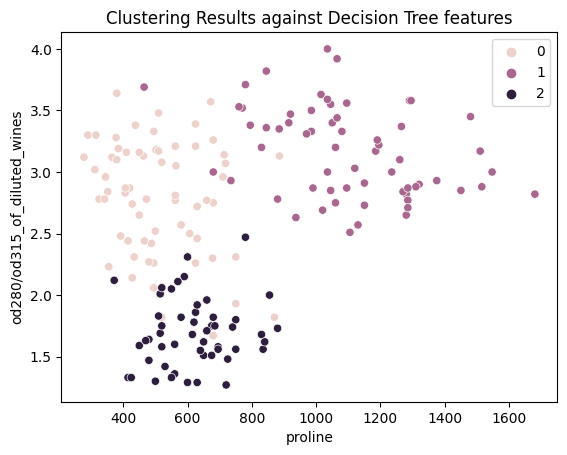

In [32]:
# Plot Features used in the Decision Tree to compare to KMeans
sb.scatterplot(x = inputDF['proline'],
               y = inputDF['od280/od315_of_diluted_wines'],
               hue = kmeans.labels_)
plt.title('Clustering Results against Decision Tree features')
plt.show()